# Sentiment analysis using Keras

#### I decided to perform sentiment analysis of airline reviews in Keras for binary classification. During the interview process it was mentioned that, besides phenotypic data, there is some unstructured data provided by medical professionals about the health of the animals. With this project, I wanted to simulate a situation where it is necessary to distinguish between positive and negative animal diagnostics to later train the model to predict the prognosis of the animals.

In [150]:
# import libraries

from numpy.random import seed
seed(100)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
tf.random.set_seed(100)
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [153]:
# import dataset

#df = pd.read_csv("/content/reviews_dataset.csv")

url = "https://raw.githubusercontent.com/jordipaloma/datasets/main/reviews_dataset.csv?token=ARPQZZOWMSXNXHD3Y2MDTJLBOGNJK"
df = pd.read_csv(url)
print(df.shape)
df.info()

(14640, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  float64
 1   sentiment                     14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  ob

In [154]:
# select specific features

df = df[['text','sentiment']]
print(df.shape)
df.head()

(14640, 2)


,text,sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [155]:
# drop "neutral" sentiment for binary classification

df = df[df['sentiment'] != 'neutral']
print(df['sentiment'].unique())
df.shape

['positive' 'negative']


(11541, 2)

In [156]:
# transform categorical values to numerical using LabelEncoder.

le = LabelEncoder()
df['sentiment'] = le.fit_transform(df['sentiment'])
df.head()

,text,sentiment
1,@VirginAmerica plus you've added commercials t...,1
3,@VirginAmerica it's really aggressive to blast...,0
4,@VirginAmerica and it's a really big bad thing...,0
5,@VirginAmerica seriously would pay $30 a fligh...,0
6,"@VirginAmerica yes, nearly every time I fly VX...",1


In [157]:
# Split features and label into train and test data

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size=0.2, random_state=1)

In [158]:
# Tokenize the texts and create dictionary from the training set

t = Tokenizer()
t.fit_on_texts(X_train)
voc_size = len(t.word_index) + 1   # extra position for index 0

# Convert texts into sequence of integers

X_train_seq = t.texts_to_sequences(X_train)
X_test_seq = t.texts_to_sequences(X_test)
print(t.word_index)
print(X_train_seq[0])
print(X_train.iloc[0])

{'to': 1, 'the': 2, 'i': 3, 'a': 4, 'you': 5, 'for': 6, 'united': 7, 'flight': 8, 'and': 9, 'on': 10, 'my': 11, 'usairways': 12, 'americanair': 13, 'is': 14, 'in': 15, 'southwestair': 16, 'of': 17, 'jetblue': 18, 'me': 19, 'your': 20, 'it': 21, 'was': 22, 'not': 23, 'no': 24, 'have': 25, 'that': 26, 'with': 27, 'at': 28, 'this': 29, 'get': 30, 'but': 31, 'be': 32, 'cancelled': 33, 'thanks': 34, 'are': 35, 'service': 36, 'now': 37, 'we': 38, 'from': 39, 'an': 40, 'just': 41, 'been': 42, '2': 43, 'customer': 44, 'so': 45, 'help': 46, 'can': 47, 'time': 48, 't': 49, 'co': 50, 'hours': 51, 'up': 52, 'http': 53, 'do': 54, 'hold': 55, 'they': 56, 'us': 57, 'amp': 58, 'out': 59, "i'm": 60, 'all': 61, 'plane': 62, 'still': 63, 'will': 64, 'what': 65, 'why': 66, 'our': 67, 'delayed': 68, 'thank': 69, 'how': 70, 'when': 71, 'call': 72, "can't": 73, 'flights': 74, 'flightled': 75, 'gate': 76, 'one': 77, 'hour': 78, 'had': 79, 'back': 80, 'if': 81, 'got': 82, 'would': 83, 'bag': 84, 'has': 85, 'af

In [159]:
max(len(l) for l in X_train_seq)

36

In [160]:
# Pad the sequences to make them of equal length

print("Max sentence length:", max(len(l) for l in X_train_seq))                                                  # Longest review in training set
sen_length = 300                                                                                                 # max sentence length
X_train_seq = pad_sequences(X_train_seq, padding='post', maxlen=sen_length)
X_test_seq = pad_sequences(X_test_seq, padding='post', maxlen=sen_length)
X_train_seq

Max sentence length: 36


array([[  16,   98, 1063, ...,    0,    0,    0],
       [   7,  119,  984, ...,    0,    0,    0],
       [  12,   24,    3, ...,    0,    0,    0],
       ...,
       [   7, 1967,   34, ...,    0,    0,    0],
       [  16,  723,   11, ...,    0,    0,    0],
       [ 108,   87,  662, ...,    0,    0,    0]], dtype=int32)

In [161]:
# Build the model 1

model = Sequential()                                                                #  Plain stack of layers where each layer has exactly one input tensor and one output tensor.

model.add(Embedding(input_dim=voc_size, output_dim=12, input_length=sen_length))    # Convert each word into a fixed length vector of defined sixze (based on feature representation)
model.add(GlobalAveragePooling1D())                                                 # downsampling
model.add(Dropout(0.50))                                                            # drop some nodes to avoid over-fitting
model.add(Dense(4, activation = "relu"))
model.add(Dropout(0.50))
model.add(Dense(1, activation = "sigmoid"))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 300, 12)           139716    
_________________________________________________________________
global_average_pooling1d_15  (None, 12)                0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 12)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 4)                 52        
_________________________________________________________________
dropout_14 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 5         
Total params: 139,773
Trainable params: 139,773
Non-trainable params: 0
_______________________________________________

In [162]:
# Train the model

history = model.fit(X_train_seq, y_train, epochs=60, batch_size= 100, validation_split=0.2)

Epoch 1/60
74/74 [==============================] - 1s 9ms/step - loss: 0.6126 - accuracy: 0.7917 - val_loss: 0.5519 - val_accuracy: 0.7840
Epoch 2/60
74/74 [==============================] - 1s 7ms/step - loss: 0.5574 - accuracy: 0.7980 - val_loss: 0.5279 - val_accuracy: 0.7840
Epoch 3/60
74/74 [==============================] - 0s 7ms/step - loss: 0.5451 - accuracy: 0.7980 - val_loss: 0.5237 - val_accuracy: 0.7840
Epoch 4/60
74/74 [==============================] - 1s 7ms/step - loss: 0.5395 - accuracy: 0.7980 - val_loss: 0.5229 - val_accuracy: 0.7840
Epoch 5/60
74/74 [==============================] - 1s 7ms/step - loss: 0.5380 - accuracy: 0.7980 - val_loss: 0.5205 - val_accuracy: 0.7840
Epoch 6/60
74/74 [==============================] - 1s 7ms/step - loss: 0.5306 - accuracy: 0.7980 - val_loss: 0.5172 - val_accuracy: 0.7840
Epoch 7/60
74/74 [==============================] - 1s 8ms/step - loss: 0.5195 - accuracy: 0.7980 - val_loss: 0.5145 - val_accuracy: 0.7840
Epoch 8/60
74/74 [==

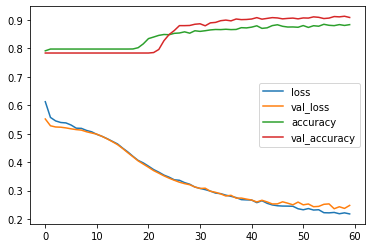

In [163]:
# Plot the loss and validation loss of the dataset

history_df = pd.DataFrame(history.history)
plt.plot(history_df['loss'], label='loss')
plt.plot(history_df['val_loss'], label='val_loss')
plt.plot(history_df['accuracy'], label='accuracy')
plt.plot(history_df['val_accuracy'], label='val_accuracy')

plt.legend()

In [164]:
# Evaluate the model

loss, accuracy = model.evaluate(X_test_seq, y_test)
print("Accuracy is : ",accuracy*100)

73/73 [==============================] - 0s 3ms/step - loss: 0.2083 - accuracy: 0.9281
Accuracy is :  92.81073808670044


In [165]:
def predict_review(text):

    sentence = t.texts_to_sequences([text])
    sentence = pad_sequences(sentence, padding='post', maxlen=300)
    prediction = model.predict(sentence).round()

    if prediction == 1.0:
      print("Positive review.", prediction)
    else:
      print("Negative review.", prediction)

In [166]:
test_review_1 = "I liked the food and the seats were pretty comfortable."
predict_review(test_review_1)

test_review_2 = "It was a very bad experience, I don't recommend them."
predict_review(test_review_2)

Positive review. [[1.]]
Negative review. [[0.]]


# CONCLUSIONS

##### In this project, I used a feed-forward neural network (or MLP), with 3 hidden layers and 1 output. The activation function of this output is "sigmoid" because it is a classification problem with a probability as an output.

##### At around 60 epochs, the model converges and gives an accuracy of 92% without overfitting.

##### The equivalent of reviews in the ClearFarm case would be medical records from vets regarding every animal and an evaluation if it is overall healthy or not. I selected short reviews because it might resemble the type of document a vet can issue on each animal (a short health report). This information could be analysed automatically to be used in other models together with phenotypic features, enviormental features, etc. 
